# All Spectrogram Code Setup

In [3]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                ord=None,
                                time_samp_prop=0.2,
                                filter_row_idx=None,                                
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# SPECIFICATION for DEMO: P41, Faces, Session 1

In [4]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = None # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

# Get all trials for by channel

In [5]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
len(all_pat_chn_trials)

all_pat_chn_trials_v = np.vstack(all_pat_chn_trials)
all_pat_chn_trials_v.shape

l1_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=1)
l2_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=2)
li_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=np.inf)

## Plot the trial norms

In [6]:
def plt_trials_norm(all_trial_norms, norm_type):
    plt.style.use('seaborn')
    plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(f'l_{norm_type}-norm for all trials', fontsize=16)
    plt.plot(all_trial_norms)
    plt.xlim(0, len(all_trial_norms))
    plt.ylabel(f'Trial index in order of channel')
    plt.ylabel(f'l_{norm_type}-norm')

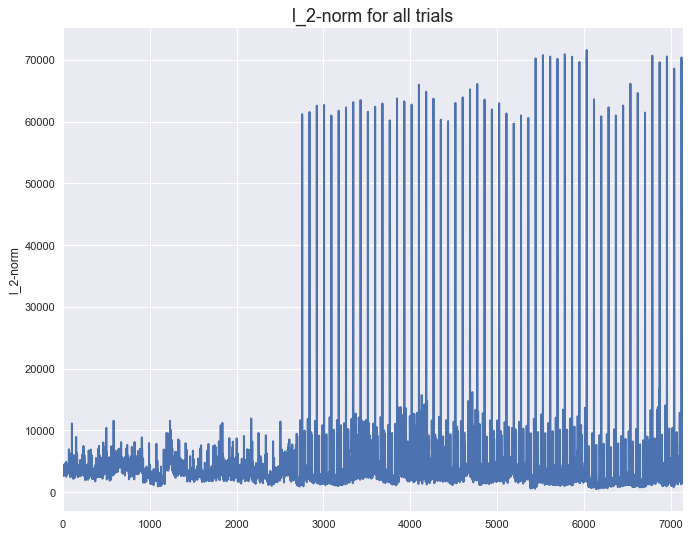

In [7]:
plt_trials_norm(all_trial_norms=l2_norm, norm_type=2)

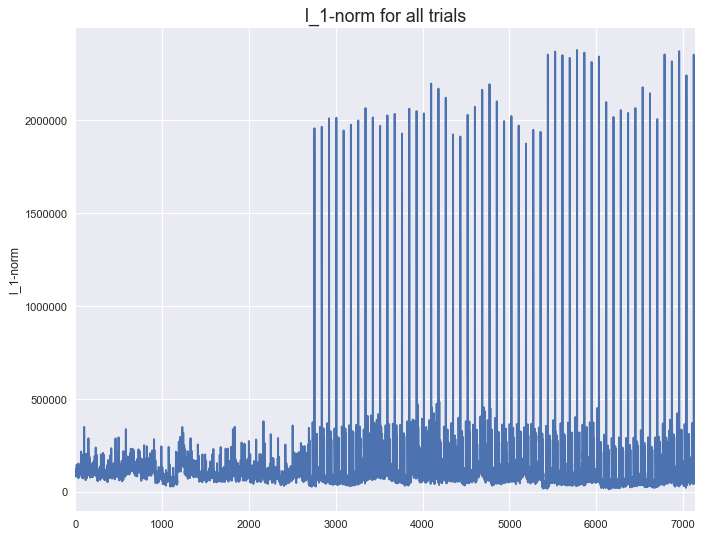

In [8]:
plt_trials_norm(all_trial_norms=l1_norm, norm_type=1)

import matplotlib.pyplot as plt
import plotly.plotly as py

y = l1_norm
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")


fig = plt.gcf()
plot_url = py.plot_mpl(fig, filename='mpl-basic-bar')

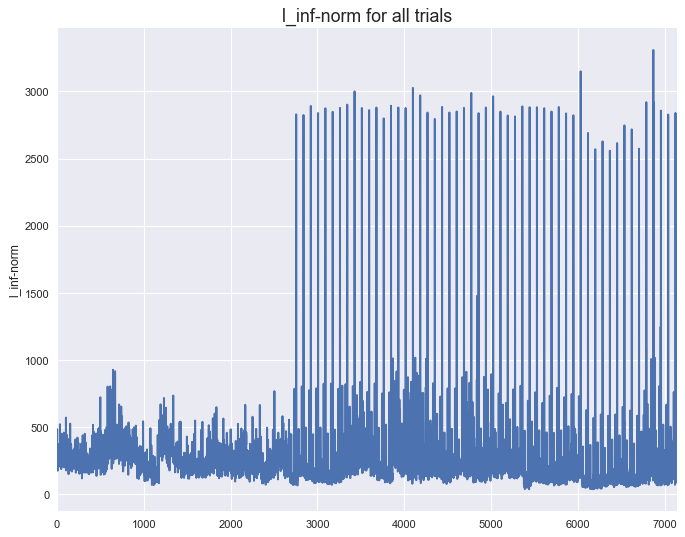

In [9]:
plt_trials_norm(all_trial_norms=li_norm, norm_type="inf")

In [10]:
def get_topk_vals_and_idx_byrow_vec(a, k, max):
    
    if max:
        # TOP-k values
        # Find sorted indices for each row
        sorted_row_idx = np.argsort(a)[a.shape[0]-k:]
    else:
        # BOTTOM-k values
        # Find sorted indices for each row
        sorted_row_idx = np.argsort(a)[range(k)]

    # Use the column-row indices to get specific elements from input array. 
    # Please note that since the column indexing array isn't of the same shape 
    # as the sorted row indices, it will be broadcasted
    top_vals = a[sorted_row_idx]
    
    return sorted_row_idx, top_vals

def get_trial_num_trial_idx(channel_num, channel_idx, outlier_loc, num_trials):
    if channel_idx == 0 and outlier_loc == 0:
        trial_num = 1
        trial_idx = 0
    elif channel_idx == 0 and outlier_loc > 0:
        trial_num = np.ceil(outlier_loc/(num_trials))
        trial_idx = trial_num - 1
    else:
        trial_num = np.ceil((outlier_loc % (channel_idx * num_trials)))
        trial_idx = trial_num - 1
    return trial_idx, trial_num

def get_outlier_indices(outlier_idx, num_trials, num_channels, ret_type):
    outlier_loc = outlier_idx + 1
    channel_num = np.ceil(outlier_loc/(num_trials))
    channel_idx = channel_num - 1

    all_combos = list(zip(channel_num, channel_idx, outlier_loc, [num_trials]*len(channel_num)))
    trial_num = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3])[1] 
                 for comb 
                 in all_combos]
    trial_idx = [get_trial_num_trial_idx(comb[0], comb[1], comb[2], comb[3])[0] 
                 for comb 
                 in all_combos]    
    
    if ret_type == "channel_num":
        out = [int(chn) for chn in channel_num]
    elif ret_type == "channel_idx":
        out = [int(chn_idx) for chn_idx in channel_idx]
    elif ret_type == "trial_num":
        out = [int(trl) for trl in trial_num]
    elif ret_type == "trial_idx":
        out = [int(trl_idx) for trl_idx in trial_idx]
    else:
        None
    
    return out

## Max 20 - Channel, Trial indices - P41, Session 1, Faces

In [11]:
k = 20

max_row_idx_l2_norm, _ = get_topk_vals_and_idx_byrow_vec(a=l2_norm, k=k, max=True)
min_row_idx_l2_norm, _ = get_topk_vals_and_idx_byrow_vec(a=l2_norm, k=k, max=False)

num_trials=all_pat_chn_trials[0].shape[0]
num_channels=len(all_pat_chn_trials)

# Get the channels corresponding to the outlier indices
channel_idx_max = get_outlier_indices(outlier_idx=max_row_idx_l2_norm, 
                                      num_trials=num_trials, 
                                      num_channels=num_channels,
                                      ret_type = "channel_idx")
trial_idx_max = get_outlier_indices(outlier_idx=max_row_idx_l2_norm, 
                                    num_trials=num_trials, 
                                    num_channels=num_channels,
                                    ret_type = "trial_idx")

# Get the channels corresponding to the outlier indices
channel_idx_min = get_outlier_indices(outlier_idx=min_row_idx_l2_norm, 
                                      num_trials=num_trials, 
                                      num_channels=num_channels,
                                      ret_type = "channel_idx")
trial_idx_min = get_outlier_indices(outlier_idx=min_row_idx_l2_norm, 
                                    num_trials=num_trials, 
                                    num_channels=num_channels,
                                    ret_type = "trial_idx")

## Checks

In [12]:
channel_idx_max
trial_idx_max
ch_trials_max = list(zip(channel_idx_max, trial_idx_max))
out_max_chk_idx= [ch_tr[0]*num_trials + ch_tr[1] for ch_tr in ch_trials_max]
ch_trials_min = list(zip(channel_idx_min, trial_idx_min))
out_min_chk_idx= [ch_tr[0]*num_trials + ch_tr[1] for ch_tr in ch_trials_min]
print(out_max_chk_idx)
print(max_row_idx_l2_norm)
print(out_min_chk_idx)
print(min_row_idx_l2_norm)

[4603, 6619, 4183, 4687, 4099, 4771, 6535, 7039, 6871, 5947, 5695, 5443, 7123, 5863, 5611, 6955, 6787, 5527, 5779, 6031]
[4603 6619 4183 4687 4099 4771 6535 7039 6871 5947 5695 5443 7123 5863
 5611 6955 6787 5527 5779 6031]
[6144, 5437, 5388, 6168, 6140, 6167, 6224, 6271, 6162, 5384, 6137, 6165, 6163, 6193, 6083, 5411, 6170, 6145, 6164, 6171]
[6144 5437 5388 6168 6140 6167 6224 6271 6162 5384 6137 6165 6163 6193
 6083 5411 6170 6145 6164 6171]


### Indices for the max-norm trials

In [14]:
ch_trials_max
sorted(ch_trials_max, key=lambda x: x[0])

[(48, 67),
 (49, 67),
 (54, 67),
 (55, 67),
 (56, 67),
 (64, 67),
 (65, 67),
 (66, 67),
 (67, 67),
 (68, 67),
 (69, 67),
 (70, 67),
 (71, 67),
 (77, 67),
 (78, 67),
 (80, 67),
 (81, 67),
 (82, 67),
 (83, 67),
 (84, 67)]

Looks like **trial index** 67 and **trial number** 68 consistently have the have the largest $L1$, $L2$ and $L_{\infty}$ norms

# SPECIFICATION for DEMO: P35, Faces, Session 1

In [13]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 35
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = None # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

# Get all trials for by channel

In [14]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)
len(all_pat_chn_trials)

all_pat_chn_trials_v = np.vstack(all_pat_chn_trials)
all_pat_chn_trials_v.shape

l1_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=1)
l2_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=2)
li_norm = np.linalg.norm(x=all_pat_chn_trials_v, axis=1, ord=np.inf)

## Plot the trial norms

In [15]:
def plt_trials_norm(all_trial_norms, norm_type):
    plt.style.use('seaborn')
    plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(f'l_{norm_type}-norm for all trials', fontsize=16)
    plt.plot(all_trial_norms)
    plt.xlim(0, len(all_trial_norms))
    plt.ylabel(f'Trial index in order of channel')
    plt.ylabel(f'l_{norm_type}-norm')

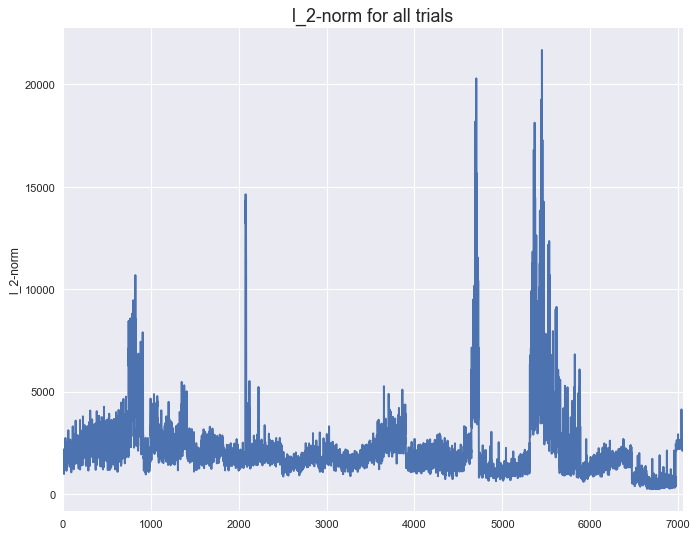

In [16]:
plt_trials_norm(all_trial_norms=l2_norm, norm_type=2)

## Max 20 - Channel, Trial indices - P35, Session 1, Faces

In [17]:
k = 20

max_row_idx_l2_norm, _ = get_topk_vals_and_idx_byrow_vec(a=l2_norm, k=k, max=True)
min_row_idx_l2_norm, _ = get_topk_vals_and_idx_byrow_vec(a=l2_norm, k=k, max=False)

num_trials=all_pat_chn_trials[0].shape[0]
num_channels=len(all_pat_chn_trials)

# Get the channels corresponding to the outlier indices
channel_idx_max = get_outlier_indices(outlier_idx=max_row_idx_l2_norm, 
                                      num_trials=num_trials, 
                                      num_channels=num_channels,
                                      ret_type = "channel_idx")
trial_idx_max = get_outlier_indices(outlier_idx=max_row_idx_l2_norm, 
                                    num_trials=num_trials, 
                                    num_channels=num_channels,
                                    ret_type = "trial_idx")

# Get the channels corresponding to the outlier indices
channel_idx_min = get_outlier_indices(outlier_idx=min_row_idx_l2_norm, 
                                      num_trials=num_trials, 
                                      num_channels=num_channels,
                                      ret_type = "channel_idx")
trial_idx_min = get_outlier_indices(outlier_idx=min_row_idx_l2_norm, 
                                    num_trials=num_trials, 
                                    num_channels=num_channels,
                                    ret_type = "trial_idx")

## Checks

In [18]:
channel_idx_max
trial_idx_max
ch_trials_max = list(zip(channel_idx_max, trial_idx_max))
out_max_chk_idx= [ch_tr[0]*num_trials + ch_tr[1] for ch_tr in ch_trials_max]
ch_trials_min = list(zip(channel_idx_min, trial_idx_min))
out_min_chk_idx= [ch_tr[0]*num_trials + ch_tr[1] for ch_tr in ch_trials_min]
print(out_max_chk_idx)
print(max_row_idx_l2_norm)
print(out_min_chk_idx)
print(min_row_idx_l2_norm)

[2077, 5444, 5429, 5427, 2081, 2080, 5469, 2076, 2079, 2082, 5373, 2078, 4709, 5357, 5456, 5367, 4693, 5440, 4703, 5450]
[2077 5444 5429 5427 2081 2080 5469 2076 2079 2082 5373 2078 4709 5357
 5456 5367 4693 5440 4703 5450]
[6698, 6781, 6755, 6729, 6760, 6677, 6646, 6756, 6711, 6794, 6744, 6672, 6715, 6910, 6905, 6749, 6719, 6681, 6652, 6739]
[6698 6781 6755 6729 6760 6677 6646 6756 6711 6794 6744 6672 6715 6910
 6905 6749 6719 6681 6652 6739]


In [19]:
ch_trials_max
sorted(ch_trials_max, key=lambda x: x[1])

[(25, 1),
 (25, 2),
 (25, 3),
 (25, 4),
 (25, 5),
 (25, 6),
 (25, 7),
 (65, 32),
 (65, 34),
 (64, 45),
 (56, 45),
 (65, 45),
 (65, 49),
 (64, 55),
 (56, 55),
 (65, 55),
 (64, 61),
 (56, 61),
 (65, 61),
 (65, 74)]

Looks like **trial index** 45/ 55/ 61 and **trial number** 46/ 56/ 62 consistently have the have the largest $L2$ norms